<a href="https://colab.research.google.com/github/2d1ff1cult/SPARK2/blob/main/RocketCEA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Notebook for testing RocketCEA

some todo:
- cross validate with actual CEA data
- validate with current MATLAB code
- validate using CH4 (F) and O2L (O) as seen in [this video](https://www.youtube.com/watch?v=9urwkTG6sCs&t=147s)

Link to RocketCEA
https://rocketcea.readthedocs.io/en/latest/quickstart.html

unrelated note:
how the heck did i find this? i was for something that tabulated cea raw data since team-written MATLAB code was buggy at times

In [ ]:
!pip install RocketCEA

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 70.1/70.1 MB 5.9 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Installing backend dependencies ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for RocketCEA: filename=rocketcea-1.2.0-cp310-cp310-linux_x86_64.whl size=5122702 sha256=2f6e67f956dab99ef90ab93d05425850f5c7400b96ddc0dc0b6a7d936093a784
  Stored in directory: /root/.cache/pip/wheels/b5/c7/42/975a9c3844aa5ba798b92814c5b2a615e4d2eb020cc3a4130f
Successfully built RocketCEA


In [ ]:
%%file chk_cea.py
from rocketcea.cea_obj import CEA_Obj
C = CEA_Obj( oxName='N2O', fuelName='CH4')
for mr in range(2,9):
    print(mr, C.get_Isp(Pc=100.0, MR=mr, eps=40.0) )

Writing chk_cea.py


In [ ]:
!python chk_cea.py

2 241.23727959118386
3 252.89115916617084
4 269.009444234883
5 283.74701925291106
6 295.13597699794934
7 303.0622845346732
8 308.40816124816536


# C* Plot test at different pressures

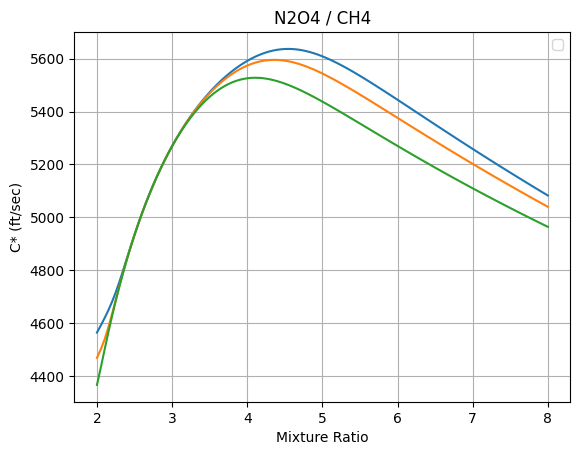

In [31]:
from rocketcea.cea_obj import CEA_Obj
from pylab import *

# sample pcL from quickstart guide of rocketcea
pcL = [2000., 500., 70.]

# note that you can use common ox/fuels' equations
ispObj = CEA_Obj(propName='', oxName='N2O4', fuelName="CH4")

for Pc in pcL:
  cstararr = []
  MR = 2.0
  mrarr = []
  while MR < 8.0:
    cstararr.append(ispObj.get_Cstar( Pc=Pc, MR=MR))
    mrarr.append(MR)
    MR += 0.05
  plot(mrarr,cstararr,label='Pc=%g psia'%Pc)

legend(loc='best')
grid(True)
title(ispObj.desc)
xlabel('Mixture Ratio')
ylabel('C* (ft/sec)')

show()

# Isp Plot test

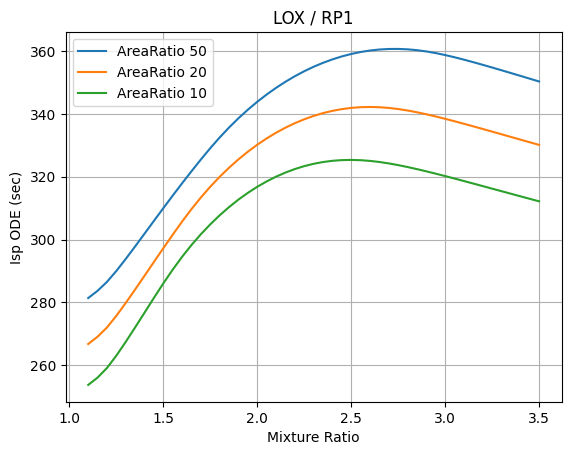

In [ ]:
from rocketcea.cea_obj import CEA_Obj
from pylab import *

Pc = 500.0

ispIRFNA = CEA_Obj(propName='', oxName='LOX', fuelName="RP1")
for e in [50.0,20.0,10.0]:
    ispArr = []
    MR = 1.1
    mrArr = []
    while MR < 3.5:
        ispArr.append( ispIRFNA(Pc, MR, e ))
        mrArr.append(MR)
        MR += 0.05
    plot(mrArr, ispArr, label='AreaRatio %g'%e)

legend(loc='best')
grid(True)
title( ispIRFNA.desc )
xlabel( 'Mixture Ratio' )
ylabel( 'Isp ODE (sec)' )
# savefig('cea_plot.png', dpi=120)

show()

# Simultaneous MR v. Isp graphs

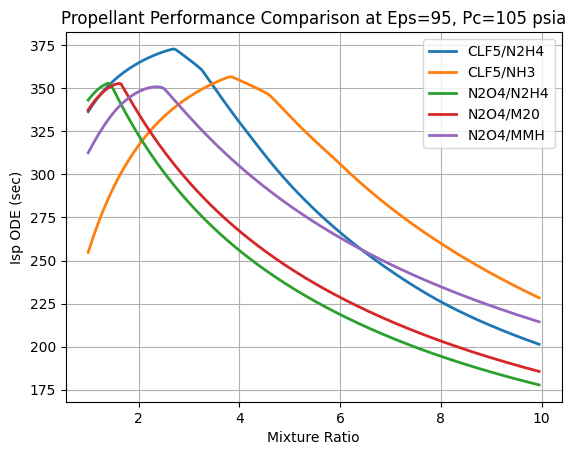

In [ ]:
from rocketcea.cea_obj import CEA_Obj
from pylab import *

Pc = 105.0
eps = 95.0
mrMin = 1.0
mrStep = 0.05
mrMax = 10.0

mrL = [mrMin + i*mrStep for i in range( int((mrMax-mrMin)/mrStep))]
ispLL = [] # a list of lists of Isp data

for oxName,fuelName in [('N2O4','N2H4'),('N2O4','MMH'),('N2O4','M20'),
    ('CLF5','N2H4'),('CLF5','NH3')]:

    ispObj = CEA_Obj( oxName=oxName, fuelName=fuelName )

    ispL = [ispObj.get_Isp(Pc=Pc, MR=MR, eps=eps) for MR in mrL]
    ispLL.append( [max(ispL), '%s/%s'%(oxName,fuelName), ispL] )

ispLL.sort(reverse=True) # sort in-place from high to low

for maxIsp, name, ispL in ispLL:
    plot(mrL, ispL, label=name, linewidth=2)

legend(loc='best')
grid(True)
title( 'Propellant Performance Comparison at Eps=%g, Pc=%g psia'%(eps,Pc) )
xlabel( 'Mixture Ratio' )
ylabel( 'Isp ODE (sec)' )
savefig('cea_compare2.png', dpi=120)

show()

# O/F vs. Isp with sliders

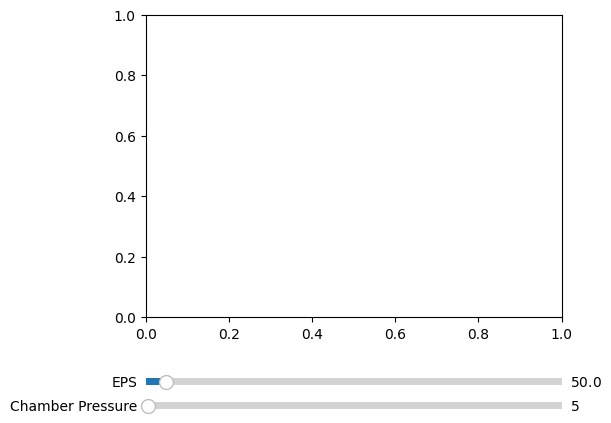

In [ ]:
from rocketcea.cea_obj import CEA_Obj
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.widgets import Button, Slider

Pc = 500.0
eps = 27.0
mrMin = 0.01
mrStep = 0.05
mrMax = 10.0

# Create the figure and the line that we will manipulate
fig, ax = plt.subplots()




# adjust the main plot to make room for the sliders
fig.subplots_adjust(left=0.25, bottom=0.25)

# Make a horizontal slider to control the frequency.
boxeps = fig.add_axes([0.25, 0.1, 0.65, 0.03])
slidereps = Slider(
    ax=boxeps,
    label='EPS',
    valmin=0.1,
    valmax=1000,
    valinit=50,
    orientation="horizontal"
)

# Make a vertically oriented slider to control the amplitude
boxpc = fig.add_axes([0.25, 0.05, 0.65, 0.03])
sliderpc = Slider(
    ax=boxpc,
    label="Chamber Pressure",
    valmin=0,
    valmax=1000,
    valinit=5,
    orientation="horizontal"
)


# The function to be called anytime a slider's value changes
def update(val):
    ax.clear()
    Pc = sliderpc.val
    eps = slidereps.val
    mrL = [mrMin + i*mrStep for i in range( int((mrMax-mrMin)/mrStep))]
    ispLL = [] # a list of lists of Isp data
    for oxName,fuelName in [('N2O4','N2H4'),('N2O4','MMH'),('N2O4','M20'),
        ('CLF5','N2H4'),('CLF5','NH3')]:

        ispObj = CEA_Obj( oxName=oxName, fuelName=fuelName )

        ispL = [ispObj.get_Isp(Pc=sliderpc.val, MR=MR, eps=slidereps.val) for MR in mrL]
        ispLL.append( [max(ispL), '%s/%s'%(oxName,fuelName), ispL] )

    ispLL.sort(reverse=True) # sort in-place from high to low

    for maxIsp, name, ispL in ispLL:
        ax.plot(mrL, ispL, label=name, linewidth=2)

    ax.legend(loc='best')
    ax.grid(True)
    plt.title( 'Propellant Performance Comparison at Eps=%g, Pc=%g psia'%(eps,Pc) )
    ax.set_xlabel( 'Mixture Ratio' )
    ax.set_ylabel( 'Isp ODE (sec)' )
    print('Pc set to: %g  EPS set to: %g'%(Pc,eps))
    # fig.canvas.draw_idle()

# register the update function with each slider
slidereps.on_changed(update)
sliderpc.on_changed(update)

plt.show()

# User prompted EPS adjustment

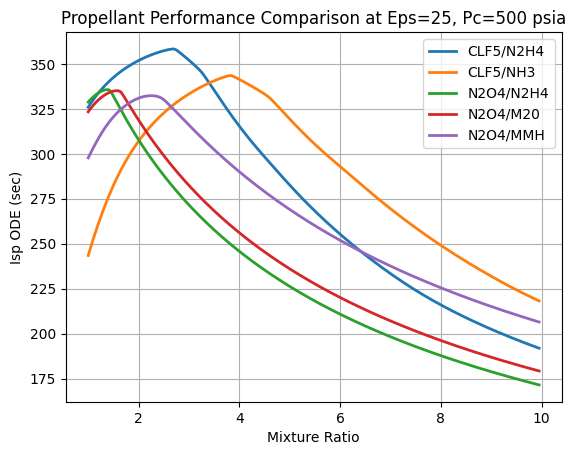

KeyboardInterrupt: Interrupted by user

In [6]:
from rocketcea.cea_obj import CEA_Obj
import matplotlib.pyplot as plt

Pc = 500.0
eps = 25.0
mrMin = 1.0
mrStep = 0.05
mrMax = 10.0


def plot_and_update(eps):
  """Plots the data and prompts for new eps value."""
  plt.cla()
  mrL = [mrMin + i*mrStep for i in range( int((mrMax-mrMin)/mrStep))]
  ispLL = [] # a list of lists of Isp data
  fuelox = [('N2O4','N2H4'),('N2O4','MMH'),('N2O4','M20'),
                          ('CLF5','N2H4'),('CLF5','NH3')]
  for oxName, fuelName in fuelox:
    ispObj = CEA_Obj( oxName=oxName, fuelName=fuelName )
    ispL = [ispObj.get_Isp(Pc=Pc, MR=MR, eps=eps) for MR in mrL]
    ispLL.append( [max(ispL), '%s/%s'%(oxName,fuelName), ispL] )

  ispLL.sort(reverse=True) # sort in-place from high to low

  for maxIsp, name, ispL in ispLL:
    plt.plot(mrL, ispL, label=name, linewidth=2)

  plt.legend(loc='best')
  plt.grid(True)
  plt.title( 'Propellant Performance Comparison at Eps=%g, Pc=%g psia'%(eps,Pc) )
  plt.xlabel( 'Mixture Ratio' )
  plt.ylabel( 'Isp ODE (sec)' )

  plt.show()

  new_eps = input("Enter new eps value (or 'q' to quit): ")
  if new_eps.lower() != 'q':
    try:
      new_eps = float(new_eps)
      # Clear the plot for redraw
      plt.cla()
      plot_and_update(new_eps)
    except ValueError:
      print("Invalid input. Please enter a number.")

plot_and_update(eps)  # initial plot

# Multiple y axes test
following https://matplotlib.org/3.4.3/gallery/ticks_and_spines/multiple_yaxis_with_spines.html

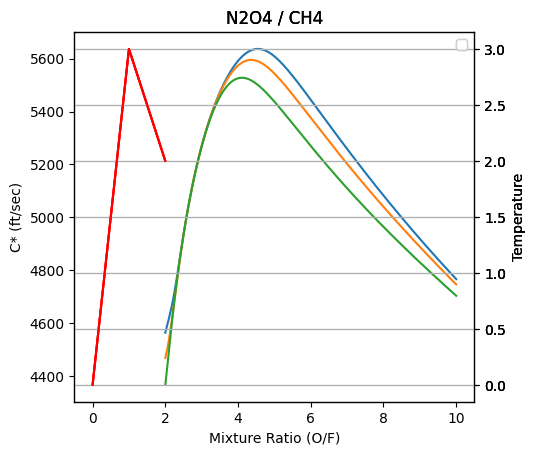

In [41]:
import matplotlib.pyplot as plt
from rocketcea.cea_obj import CEA_Obj

fig, ax = plt.subplots()
fig.subplots_adjust(right=0.75)


# sample pcL from quickstart guide of rocketcea
pcL = [2000., 500., 70.]

# note that you can use common ox/fuels' equations
ispObj = CEA_Obj(propName='', oxName='N2O4', fuelName="CH4")

for Pc in pcL:
  cstararr = []
  MR = 2.0
  mrarr = []
  label = []
  while MR < 10.0:
    cstararr.append(ispObj.get_Cstar( Pc=Pc, MR=MR))
    mrarr.append(MR)
    MR += 0.01
  ax.set_xlabel('Mixture Ratio (O/F)')
  ax.set_ylabel('C* (ft/sec)')
  ax.plot(mrarr,cstararr,label='Pc=%g psia'%Pc)
  tempx = ax.twinx()
  tempx.set_ylabel("Temperature")

  # Offset the right spine of twin2.  The ticks and label have already been
  # placed on the right by twinx above.
  tempx.spines.right.set_position(("axes", 1))

  #TODO: add fuel stuff vs. temperature
  tempplot, = tempx.plot([0, 1, 2], [0, 3, 2], "r-")

  plt.legend(loc='best')
  plt.grid(True)
  plt.title(ispObj.desc)

plt.show()

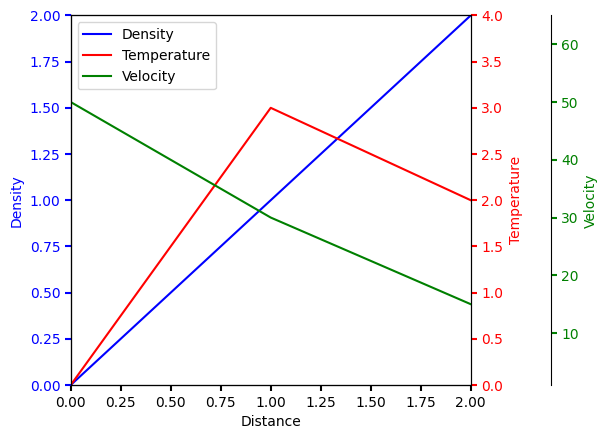

In [34]:
import matplotlib.pyplot as plt


fig, ax = plt.subplots()
fig.subplots_adjust(right=0.75)

twin1 = ax.twinx()
twin2 = ax.twinx()

# Offset the right spine of twin2.  The ticks and label have already been
# placed on the right by twinx above.
twin2.spines.right.set_position(("axes", 1.2))

p1, = ax.plot([0, 1, 2], [0, 1, 2], "b-", label="Density")
p2, = twin1.plot([0, 1, 2], [0, 3, 2], "r-", label="Temperature")
p3, = twin2.plot([0, 1, 2], [50, 30, 15], "g-", label="Velocity")

ax.set_xlim(0, 2)
ax.set_ylim(0, 2)
twin1.set_ylim(0, 4)
twin2.set_ylim(1, 65)

ax.set_xlabel("Distance")
ax.set_ylabel("Density")
twin1.set_ylabel("Temperature")
twin2.set_ylabel("Velocity")

ax.yaxis.label.set_color(p1.get_color())
twin1.yaxis.label.set_color(p2.get_color())
twin2.yaxis.label.set_color(p3.get_color())

tkw = dict(size=4, width=1.5)
ax.tick_params(axis='y', colors=p1.get_color(), **tkw)
twin1.tick_params(axis='y', colors=p2.get_color(), **tkw)
twin2.tick_params(axis='y', colors=p3.get_color(), **tkw)
ax.tick_params(axis='x', **tkw)

ax.legend(handles=[p1, p2, p3])

plt.show()